# Plot how distance between song-driven MA trajectories changes over time

In [1]:
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors, get_line_log
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)

In [5]:
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p):
    t = np.arange(len(i_s))*DT
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        
        # update integrated response
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t


def smlt_ideal(i_s, i_p, tau_r, tau_a, x_s, x_p):
    t = np.arange(len(i_s))*DT
    tau_r = 1e6
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        
        # update integrated response
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t

In [6]:
# get snippets
T_SEG = 300
NT_SEG = int(round(T_SEG*FPS))

# T_SEG_WHITE = 50*T_SEG
T_SEG_WHITE = 5*T_SEG
NT_SEG_WHITE = int(round(T_SEG_WHITE*FPS))

T_GAP = 10e10
NT_GAP = int(round(T_GAP*FPS))

t = np.arange(NT_SEG)*DT
t_white = np.arange(NT_SEG_WHITE)*DT

segs = []

for csng, sng_full in enumerate(sngs_full):

    bds = get_seg(sng_full > 0, min_gap=NT_GAP)[1]
    segs_ = [sng_full[lb:ub] for lb, ub in bds]

    # keep fixed-length portions only of sufficiently long segments
    segs_ = [seg[:NT_SEG] for seg in segs_ if (len(seg) >= NT_SEG)]

    segs.extend(segs_)
    
segs = np.array(segs)
nseg = len(segs)
print(f'{nseg} segments of duration {T_SEG}')

p_mode = [np.mean(segs==0), np.mean(segs==1), np.mean(segs==2)]

print('Frac quiet, sine, pulse:')
print(p_mode)

57 segments of duration 300
Frac quiet, sine, pulse:
[0.7374010005588953, 0.15755589439799966, 0.10504310504310505]


In [7]:
rs = np.nan*np.zeros((len(segs), len(t), N))
rs_white = np.nan*np.zeros((len(segs), len(t_white), N))
for cseg, seg in enumerate(segs):
    sys.stdout.write('.')
    i_s = seg == 1
    i_p = seg == 2
    
    rs_ = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)[0]
    rs[cseg, :, :] = rs_
    
    seg_white = np.random.choice([0, 1, 2], len(t_white), p=p_mode)
    i_s_white = (seg_white == 1)
    i_p_white = (seg_white == 2)
    
    rs_white[cseg, :, :] = smlt_ideal(i_s_white, i_p_white, tau_r, tau_a, x_s, x_p)[0]

.........................................................

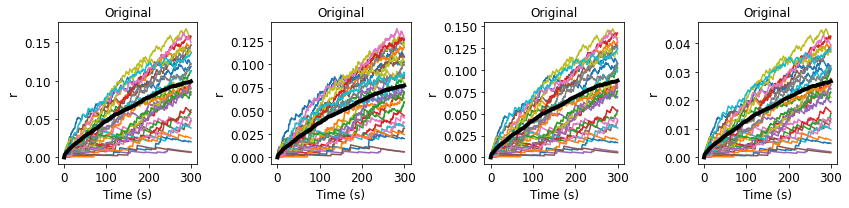

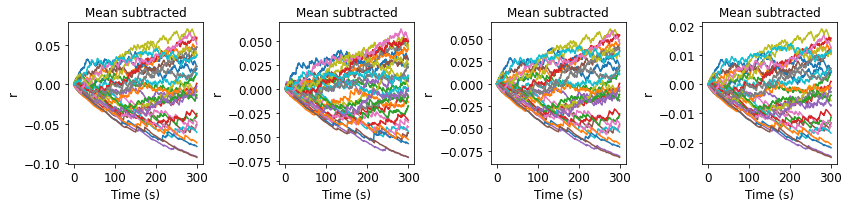

In [8]:
N_SEG_PLOT = 30
rs_mn = rs.mean(axis=0)
rs_mn_zero = rs - rs_mn

fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
for cseg in range(N_SEG_PLOT):
    for cax, ax in enumerate(axs):
        ax.plot(t, rs[cseg, :, cax])
        
for cax, ax in enumerate(axs):
    ax.plot(t, rs_mn[:, cax], c='k', lw=4)
    set_plot(ax, x_label='Time (s)', y_label='r', title='Original')
    
fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
for cseg in range(N_SEG_PLOT):
    for cax, ax in enumerate(axs):
        ax.plot(t, rs_mn_zero[cseg, :, cax])
        
for cax, ax in enumerate(axs):
    set_plot(ax, x_label='Time (s)', y_label='r', title='Mean subtracted')
    
rs_white_mn = rs_white.mean(axis=0)
rs_white_mn_zero = rs_white - rs_white_mn

In [9]:
# compute rms displacement of zero-mean trajectories
rmsds = np.nan*np.zeros((nseg, len(t)))

for cseg in range(nseg):
    rmsds[cseg, :] = np.linalg.norm(rs_mn_zero[cseg, :, :], axis=1)
    
rmsd_whites = np.nan*np.zeros((nseg, len(t_white)))

for cseg in range(nseg):
    rmsd_whites[cseg, :] = np.linalg.norm(rs_white_mn_zero[cseg, : ,:], axis=1)

Slope = 0.703892727684872
Slope = 0.4794387196251666


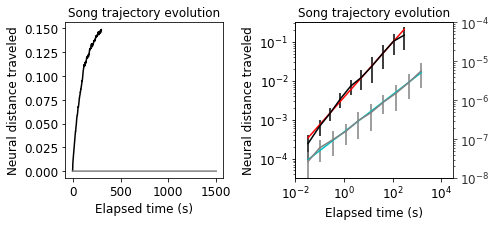

In [10]:
from disp import set_color

fig, axs = plt.subplots(1, 2, figsize=(7, 3.25), tight_layout=True)
axs[0].plot(t, rmsds.mean(0), c='k')
mt = np.round(np.logspace(0, np.log10(len(t)-1), 10)).astype(int)
axs[1].errorbar(t[mt], rmsds.mean(0)[mt], yerr=np.std(rmsds, axis=0)[mt], c='k')

x_ln, y_ln, (slp, icpt, r, p, sterr) = get_line_log(t[t>0], rmsds.mean(0)[t>0])
print(f'Slope = {slp}')

axs[1].plot(10**x_ln, 10**y_ln, c='r')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(10**-4.5, 10**-0.5)

axs[0].plot(t_white, rmsd_whites.mean(0), c='gray')
mt_white = np.round(np.logspace(0, np.log10(len(t_white)-1), 10)).astype(int)

ax_1_twin = axs[1].twinx()
ax_1_twin.errorbar(t_white[mt_white], rmsd_whites.mean(0)[mt_white], yerr=np.std(rmsd_whites, axis=0)[mt_white], c='gray')

x_ln, y_ln, (slp, icpt, r, p, sterr) = get_line_log(t_white[mt_white], rmsd_whites.mean(0)[mt_white])
print(f'Slope = {slp}')

ax_1_twin.plot(10**x_ln, 10**y_ln, c='c')
ax_1_twin.set_xscale('log')
ax_1_twin.set_yscale('log')
ax_1_twin.set_ylim(10**-8, 10**-4)

set_plot(ax_1_twin)
set_color(ax_1_twin, (.2, .2, .2))

axs[1].set_xlim(10**-2, 10**4.5)

for ax in axs:
    set_plot(ax, x_label='Elapsed time (s)', y_label='Neural distance traveled', title='Song trajectory evolution')

fig.savefig('ms/fig_5_song_trj_evolution.svg')

In [23]:
# song separation
NTR = 30
NPAIR = 100

ds_all = []
d_whites_all = []

slps = []
slp_whites = []

icpts = []
icpt_whites = []

for ctr in range(NTR):
    sys.stdout.write('.')
    ds = np.nan*np.zeros((NPAIR, len(t)))
    for cpair in range(NPAIR):
        idx_0, idx_1 = np.random.choice(np.arange(nseg), 2, replace=False)
        ds[cpair, :] = np.linalg.norm(rs[idx_0, :, :]-rs[idx_1, :, :], axis=1)

    d_whites = np.nan*np.zeros((NPAIR, len(t_white)))
    for cpair in range(NPAIR):
        idx_0, idx_1 = np.random.choice(np.arange(nseg), 2, replace=False)
        d_whites[cpair, :] = np.linalg.norm(rs_white[idx_0, :, :]-rs_white[idx_1, :, :], axis=1)

    x_ln, y_ln, (slp, icpt, r, p, sterr) = get_line_log(t[t>0], ds.mean(0)[t>0])
    x_ln_white, y_ln_white, (slp_white, icpt_white, r, p, sterr) = get_line_log(t_white[mt_white], d_whites.mean(0)[mt_white])
    
    ds_all.append(copy(ds))
    d_whites_all.append(copy(d_whites))
    
    slps.append(slp)
    slp_whites.append(slp_white)
    
    icpts.append(icpt)
    icpt_whites.append(icpt_white)

..............................

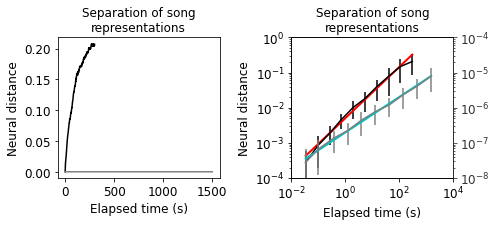

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.25), tight_layout=True)
axs[0].plot(t, ds.mean(0), c='k')
axs[1].errorbar(t[mt], ds.mean(0)[mt], yerr=np.std(ds, axis=0)[mt], c='k')

axs[1].plot(10**x_ln, 10**y_ln, c='r', lw=2)
axs[1].set_ylim(10**-4, 10**0)
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].plot(t_white, d_whites.mean(0), c='gray')
ax_1_twin = axs[1].twinx()
ax_1_twin.errorbar(t_white[mt_white], d_whites.mean(0)[mt_white], yerr=np.std(d_whites, axis=0)[mt_white], c='gray')

ax_1_twin.plot(10**x_ln_white, 10**y_ln_white, c='c', lw=2)
ax_1_twin.set_xscale('log')
ax_1_twin.set_yscale('log')
ax_1_twin.set_ylim(1e-8, 1e-4)

set_plot(ax_1_twin)
set_color(ax_1_twin, (.2, .2, .2))

axs[1].set_xlim(10**-2, 10**4)

for ax in axs:
    set_plot(ax, x_label='Elapsed time (s)', y_label='Neural distance', title='Separation of song\nrepresentations')

fig.savefig('ms/fig_5_song_separation.svg')

In [27]:
print('Slope mean, std:', np.mean(slps), np.std(slps))
print('Slope (white) mean, std:', np.mean(slp_whites), np.std(slp_whites))

Slope mean, std: 0.7224143694968174 0.01079096498294687
Slope (white) mean, std: 0.49781964370436893 0.01270256211289646


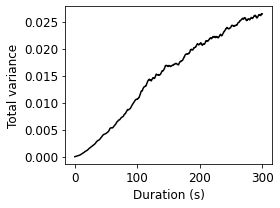

In [13]:
# compute how variance of point cloud changes over time
v = np.nan*np.zeros(len(t))
for ct in range(len(t)):
    v[ct] = np.trace(np.cov(rs[:, ct, :], rowvar=False))
    
# v_white = np.nan*np.zeros(len(t_white))
# for ct in range(len(t_white)):
#     v_white[ct] = np.trace(np.cov(rs_white[:, ct, :], rowvar=False))
    
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.plot(t, v, c='k')
# ax.plot(t_white, v_white, c='gray')
set_plot(ax, x_label='Duration (s)', y_label='Total variance')

fig.savefig('ms/fig_5_song_trj_variance.svg')